## Analisis de la camara Canon 600D 
Este análisis se basa en la captura de BIAS y DARKFRAMES a una a temperatura fija de 10 C y con diferentes ganancias. Se capturan 10 FRAMES de cada tipo, usando desde la linea de comandos y con la camara conectada, el programa auxiliar captura_DARKS_and_BIAS.py que hace todas las capturas.

In [1]:
import numpy as np
import pandas as pd
import math
import os
import rawpy
import astropy.io.fits as fits
from matplotlib.colors import LogNorm,PowerNorm
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10
%matplotlib inline



# BIAS FRAME 
Miro el histograma de los bias y si hay puntos con valor cero lo cual significaria que el offset (ASI_BRIGHTNESS) no es suficiente y hay que aumentarlo para que no haya recortes

In [11]:
#funciones  auxiliar para pintar los histogramas y mostrar los datos

def readCR2(filename):
    with rawpy.imread(filename) as raw:
        rgb = raw.postprocess(use_camera_wb=True,output_bps=16,user_flip=0)
        raw_image = raw.raw_image.copy()
    return raw_image

   
def CR2_hist(filename):
    v=readCR2(filename)
    array_hist(v,title=filename)
    
def array_hist(v,title=None):
    print("SIZE:",v.shape)
    num_bins=200
    plt.imshow(v, norm=LogNorm())
    if title is not None:
        plt.title("lognormal of:"+title)
    plt.plot()
    #plt.xscale('log')
    plt.hist(v.reshape(-1),bins=500)
    if title is not None:
        plt.title("Histograma of:"+title)
    plt.plot()
    print("MIN/MAX/MEAN/STD",v.min(),v.max(),v.mean(),v.std())
    
def show_cacho(v,size=200):
    plt.imshow(v[0:size,0:size], norm=LogNorm())
    plt.title("Detalle")
    plt.plot()

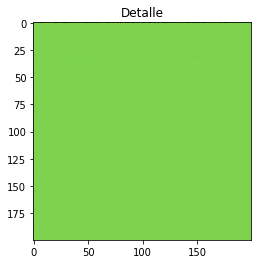

In [12]:
filename='../BIAS/IMG_7286.CR2'
v=readCR2(filename)
show_cacho(v)


SIZE: (3516, 5344)
MIN/MAX/MEAN/STD 1 16378 2049.6343130718087 204.23823511775356


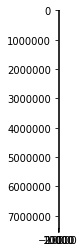

In [13]:
array_hist(v)

In [14]:
np.count_nonzero((v % 4 == 0))
# parece que está cuantizado a 4,los valores de todos los pixeles son divisibles por 4
# esto es coherente con un ADC de 14bits mapeado a 16bit (uint16)

4671740

Resuelto este tema:

> "Se aprecian tres zonas diferenciadas. Corresponde a las distintas poblaciones de pixeles R,G,B que parecen tener ganancias diferentes. Para mi es un resultado no esperado ya que este Frame es un bias sin exposicion a la luz con lo que esperaba todos los pixeles se comportaran de forma similar."

El motivo es que se aplican diferentes ganancias dependiendo del balance de blancos que tenga la camara. Es decir el balance de blancos se guarda en el FITS. Para que sea neutro asi.ASI_WB_R=50 y asi.ASI_WB_B=50

Por otra parte no hay ningun valor a cero con lo que el offset es suficente a 20. Estas es un tabla indicativa confeccionada con lecturas manuales:

|ASI_BRIGHTNESS|MEAN ADU|
|--------------|--------|
|0|2.1|
|10|870|
|50|4375|
|60|5252|
|70|6127|
|75|6565|
|80|7000|

# DARK FRAME
Hago lo mismo con un dark

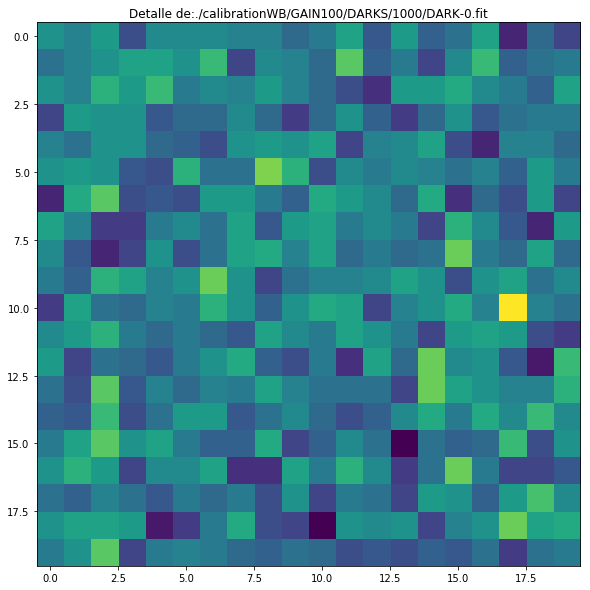

In [26]:
fitname=base_dir+'/GAIN100/DARKS/1000/DARK-0.fit'
show_cacho(fitname)

SIZE: (2822, 4144)
MIN/MAX/MEAN/STD 792 10264 1272.632949467641 19.525595792348035


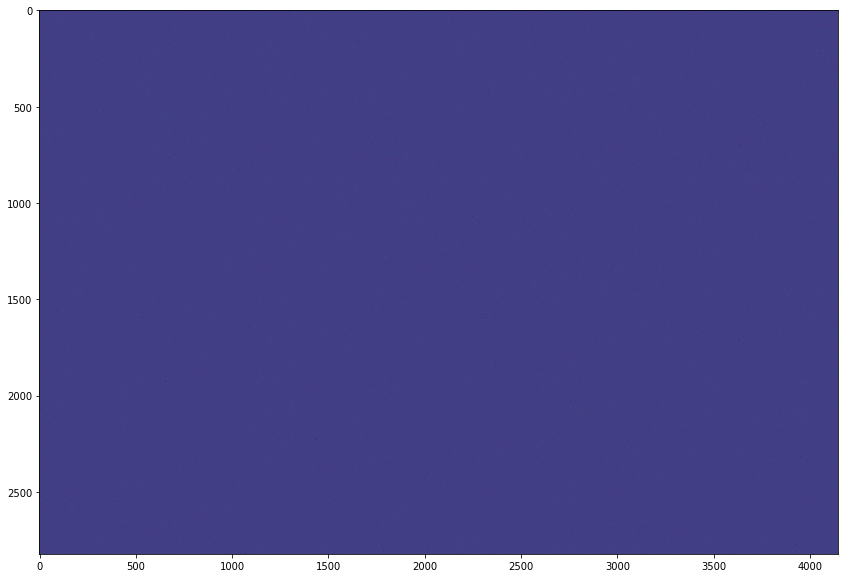

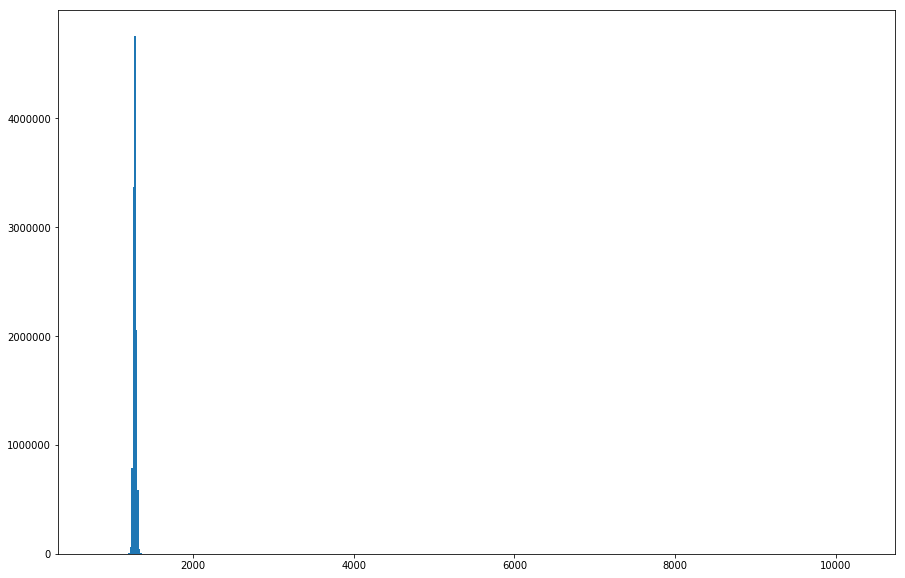

In [27]:
v=fits_values(fitname)
array_hist(v)

# Calculo de los MASTERFRAMES

Los FRAMES de cada tipo y se promedian para hacer un MASTERBIAS/MASTERDARK usando el estadistico 'median'. Luego se calcula el valor medio de todos los pixeles y su std. Los resultados se guardan en los ficheros bias.csv y darks.csv. 

Tarda en ejecutarse por lo que tiene un *if True* al principio por si ya se han generado los ficheros bias.csv y darks.csv y no se quiere ejecutar otra vez

In [29]:
if False:
    dark_result=[]
    bias_result=[]

    for g in gains:
        print("========= GAIN ",g," ===========")
        d='./'+base_dir+'/GAIN'+str(g)
        bias=[]
        bias += [each for each in os.listdir(d+'/BIAS') if each.endswith('.fit')]
        _bias=map(lambda x: d+'/BIAS/'+x,bias)
        print("Promediando BIAS frame. GAIN=",g)
        Cbias=fitsMaths.combine(_bias)
        dd=Cbias.hdulist[0].data
        bias_result.append((10,g,dd.mean(),dd.std()))
        Cbias.save(d+'/masterbias_gain_'+str(g)+'.fit')
        for darktime in darks_times:
                darks=[]
                darks += [each for each in os.listdir(d+'/DARKS/'+str(darktime)) \
                          if each.endswith('.fit')]
                _darks=map(lambda x: d+'/DARKS/'+str(darktime)+'/'+x,darks)
                print("")
                print("Promediando DARK frame. GAIN=",g," EXPOSURE=",darktime)
                ff=fitsMaths.combine(_darks)
                f=ff-Cbias
                #f=ff
                dd=f.hdulist[0].data
                dark_result.append((10,g,darktime,dd.mean(),dd.std()))
                f.save(d+'/masterdark_gain_'+str(g)+'_exp_'+str(darktime)+'.fit')
                
    Abias = np.array(bias_result)
    np.savetxt("bias.csv", Abias, delimiter=",",header='TEMP,GAIN,MEAN,SDT')

    Adark = np.array(dark_result)
    np.savetxt("dark.csv", Adark, delimiter=",",header='TEMP,GAIN,EXP,MEAN,SDT')


# Muestras de Masterbias

SIZE: (2822, 4144)
MIN/MAX/MEAN/STD 1044.0 1760.0 1271.3414785647244 7.434018400585838


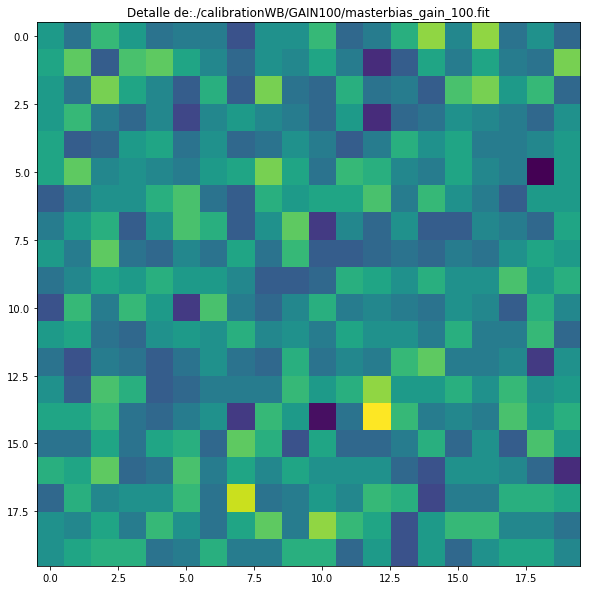

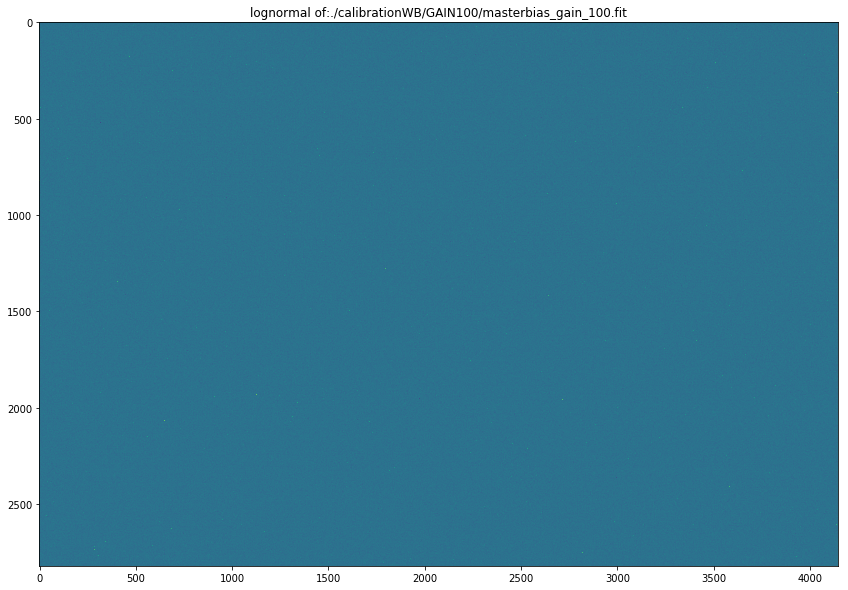

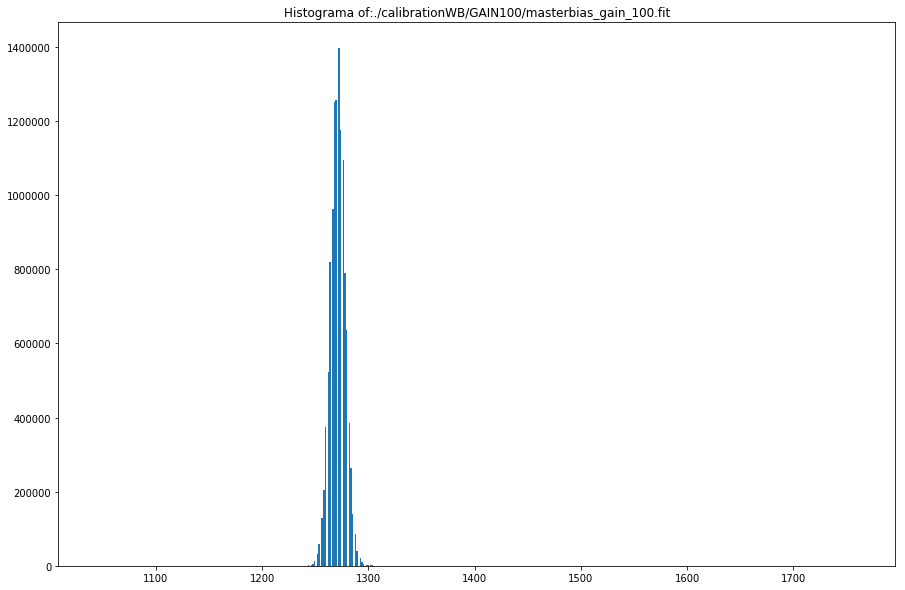

In [11]:
fitname=base_dir+'/GAIN100/masterbias_gain_100.fit'
show_cacho(fitname)
fits_hist(fitname)

# Muestra de Masterdark

SIZE: (2822, 4144)
MIN/MAX/MEAN/STD -616.0 40588.0 5.807752928589215 25.74394510937141


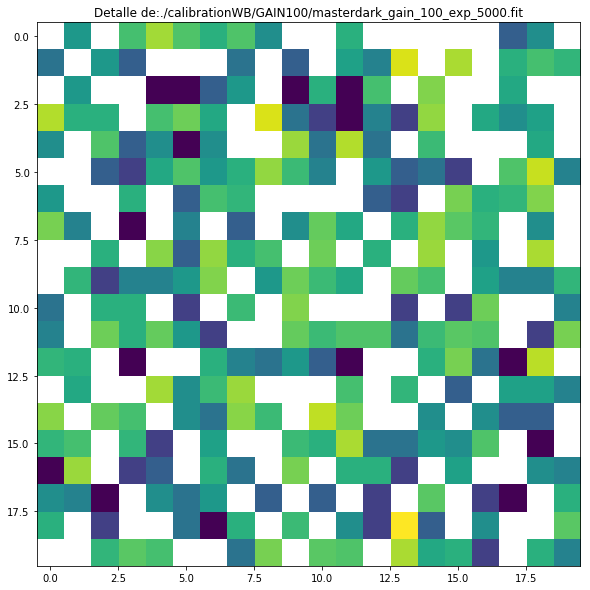

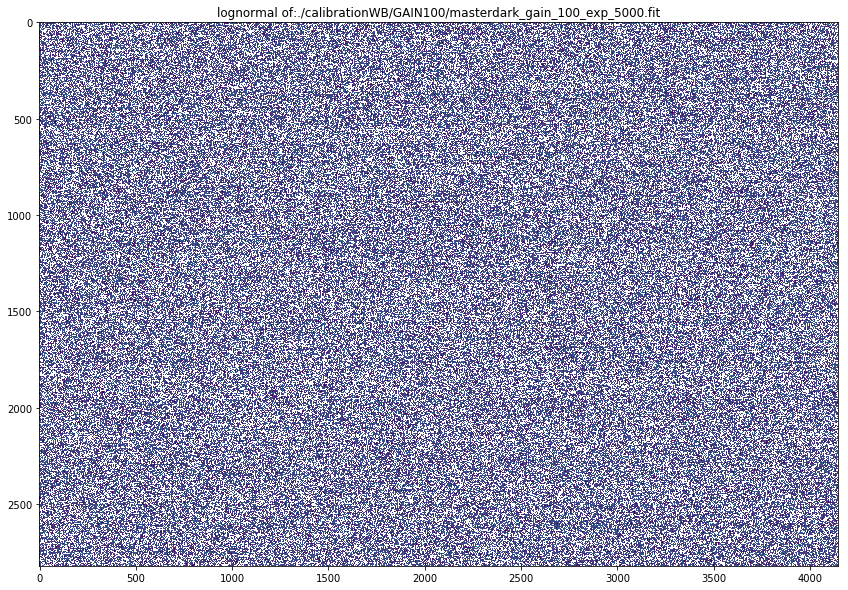

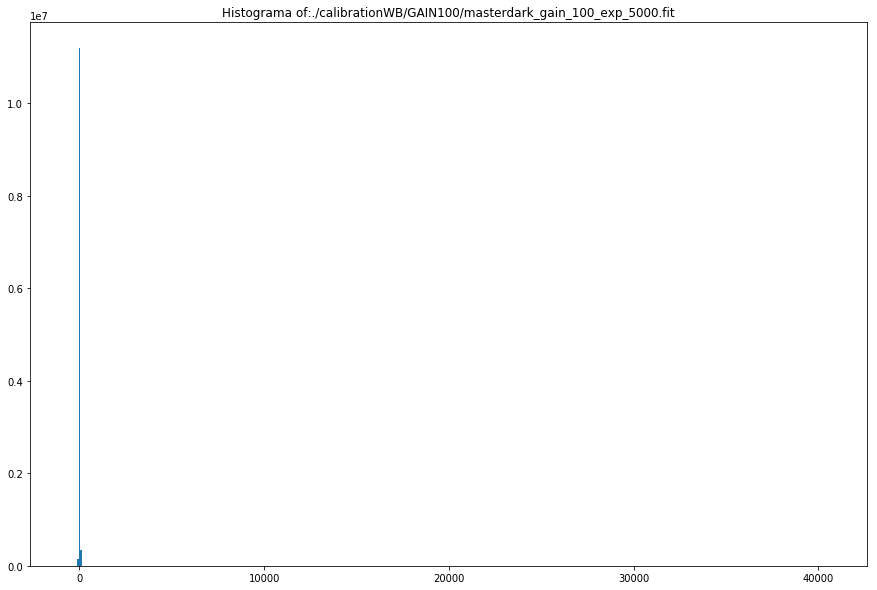

In [24]:
G='100'
E='5000'
fitname=base_dir+'/GAIN'+G+'/masterdark_gain_'+G+'_exp_'+E+'.fit'
show_cacho(fitname)
fits_hist(fitname)

# Variación de los BIAS para distintos valores de GAIN

In [23]:
bias=pd.read_csv("bias.csv")
bias

,# TEMP,GAIN,MEAN,SDT
0,10.0,1.0,1269.244823,3.029826
1,10.0,100.0,1271.341479,7.434018
2,10.0,200.0,1281.436136,7.460790
3,10.0,300.0,1283.925938,21.460530
4,10.0,400.0,1291.658115,66.219545
5,10.0,500.0,1315.958286,206.159003
6,10.0,570.0,1361.766797,461.323995


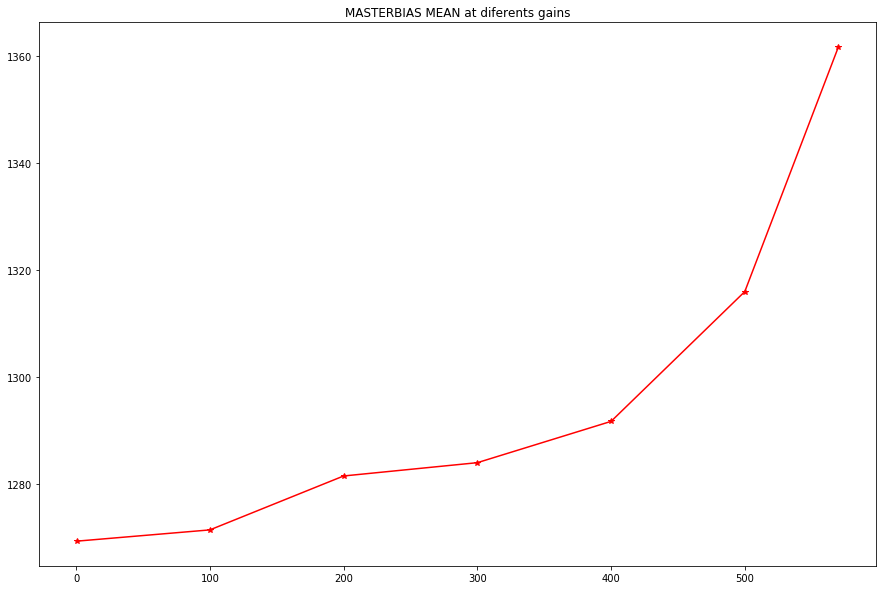

In [14]:
plt.figure(figsize=(15,10))
plt.plot(bias.GAIN,bias.MEAN,'r',marker='*')
plt.title('MASTERBIAS MEAN at diferents gains')
plt.show()

Se ve una variacion muy abrupta comenzando en gain=400.

# Variación de los MASTERDARK para distintos valores de GAIN y EXPOSURE

In [15]:
dark_df=pd.read_csv("dark.csv")
dark_df

,# TEMP,GAIN,EXP,MEAN,SDT
0,10.0,1.0,1000.0,0.672329,8.299921
1,10.0,1.0,5000.0,1.250830,9.889380
2,10.0,1.0,10000.0,1.914755,11.709299
3,10.0,1.0,15000.0,2.937344,12.615118
4,10.0,100.0,1000.0,3.879317,20.602513
5,10.0,100.0,5000.0,5.807753,25.743945
6,10.0,100.0,10000.0,8.393902,30.205477
7,10.0,100.0,15000.0,9.881262,32.330540
8,10.0,200.0,1000.0,0.314719,21.931996
9,10.0,200.0,5000.0,1.869423,36.582764


In [16]:
dark={}
gains=set(dark_df.GAIN)
for g in gains:
    dark[g]=dark_df[dark_df.GAIN==g]

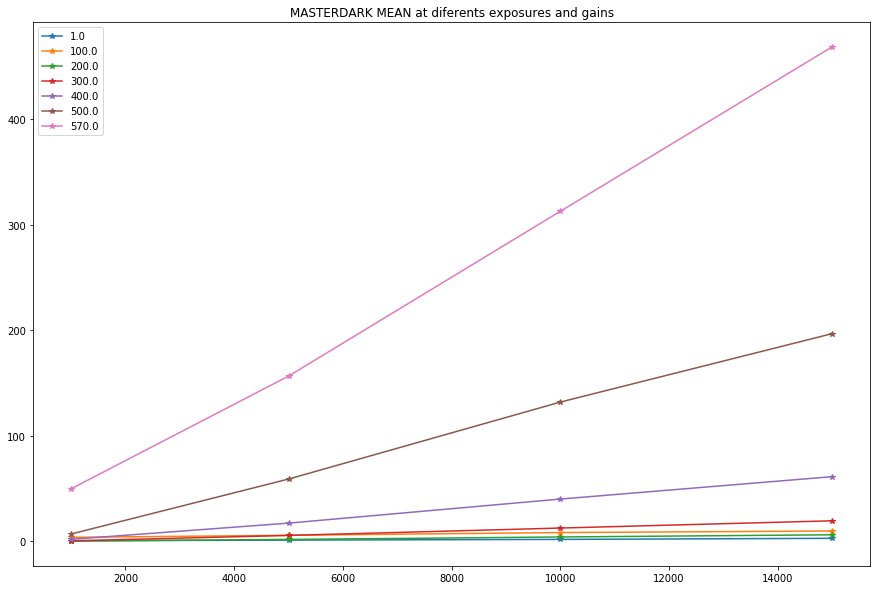

In [17]:
plt.figure(figsize=(15,10))
for g in gains:
    plt.plot(dark[g].EXP,dark[g].MEAN,marker='*')
plt.legend(gains)
plt.title('MASTERDARK MEAN at diferents exposures and gains')
plt.show()

Parece muy lineal. Aprovecho para intentar verificar la ganancia. La ganancia de la 294 Pro está expresada en decimas de dB. Esto es 100 corresponde a 10.0dB. 

In [21]:
a=dark[300].MEAN.values
b=dark[100].MEAN.values
c=a/b
for i,e in enumerate(darks_times):
    print(20*math.log10(abs(c[i])))

-17.234811556975696
-0.18028918572217317
3.5758109732931906
5.922765442052325


Comparando las ganancias a 300 (30.db) y 100(10.dB) sale aprox 20 (sobre lso 30db-10db=20.0db teoricos). Con otros valores de ganancias sale peor con errores de 3db.
